Enron email analysis final project Udacity Intro to Machine Learning for Data Analysis by Kort Linden
 
Enron was an enromus company with profits that never stopped going up.  The problems was it was a house of cards built with shell companies and profits based on nothing but paper.  The scandle reached many people and I will play dectective by comparing known POIs (persons of interest) and their corresponding features to the features of a corpus of enron employees. I will read in the data, explore it for outliers, clean it, create new features from the existing features using a formula and then run various classifiers from the sklearn package.  

In [1]:
#!/usr/bin/python

import matplotlib.pyplot as plt
import sys
import numpy
import pickle
from sklearn import preprocessing
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.grid_search import GridSearchCV
import pandas

import sklearn
from ggplot import *
import matplotlib
%matplotlib inline
sys.path.append("../tools/")


from feature_format import featureFormat
from feature_format import targetFeatureSplit


### features_list is a list of strings, each of which is a feature name
### first feature must be "poi", as this will be singled out as the label

###People will be sorted by poi

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWar

I will now create my features list and add the names for the new features I will be creating. 

In [2]:

### I'm looking for a feature most realted to POI's

# The financial features may be related to in some combination to illegal payments to POIs.

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'ratio_to_poi', 'ratio_from_poi', 'total_poi_ratio'] 


NAN_value = 'NaN'

Loading the data set. I will remove some outliers I found by using the code I created for the outliers section of this course.  "Total" is a spread sheet error, Mr. "Lockart" has not data at all and "The Travel Agency in the park" is not a person.  Other numerical outliers were identified but were not removed or scaled as they were accurate representations of the entry.  I will then take a cursury look at the data.

In [3]:
### load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )
data_dict.pop("TOTAL", 0) 
data_dict.pop('LOCKHART EUGENE E', 0) 
data_dict.pop('THE TRAVEL AGENCY IN THE PARK', 0)

### look at data
print len(data_dict.keys())
print data_dict['BUY RICHARD B']
#print data_dict.values()

143
{'salary': 330546, 'to_messages': 3523, 'deferral_payments': 649584, 'total_payments': 2355702, 'exercised_stock_options': 2542813, 'bonus': 900000, 'restricted_stock': 901657, 'shared_receipt_with_poi': 2333, 'restricted_stock_deferred': 'NaN', 'total_stock_value': 3444470, 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 1053, 'other': 400572, 'from_this_person_to_poi': 71, 'poi': False, 'director_fees': 'NaN', 'deferred_income': -694862, 'long_term_incentive': 769862, 'email_address': 'rick.buy@enron.com', 'from_poi_to_this_person': 156}


Now, I will convert to a data frame so I can use pandas to take a look and manipulate the data.


In [5]:
df = pandas.DataFrame.from_records(list(data_dict.values()))
print df.head()

     bonus deferral_payments deferred_income director_fees  \
0   600000               NaN             NaN           NaN   
1  1200000           1295738        -1386055           NaN   
2   350000               NaN         -400729           NaN   
3      NaN               NaN             NaN           NaN   
4  1500000               NaN        -3117011           NaN   

              email_address exercised_stock_options expenses from_messages  \
0      mark.metts@enron.com                     NaN    94299            29   
1                       NaN                 6680544    11200           NaN   
2  steven.elliott@enron.com                 4890344    78552           NaN   
3     bill.cordes@enron.com                  651850      NaN            12   
4    kevin.hannon@enron.com                 5538001    34039            32   

  from_poi_to_this_person from_this_person_to_poi        ...         \
0                      38                       1        ...          
1               

I see alot of NaN values so first I will convert them for better use with with my algorythms.  I will then filter out columns that have more than 65 NaN values.  The reason I did this is because I tested it with the variable that have more than 120 NaNs and this was not sufficient to reach my targed recall and precision. I also came back to this section to filter out 'director_fees" category since the decision tree ranked it as the least important feature. Then, I will print out the list count to see if there are more NaN values.

In [6]:

df.replace(to_replace='NaN', value=numpy.nan, inplace=True)

# Print a count of NaNs per variable
print df.isnull().sum()

# Create framework to eliminate variables with too many NaNs
print df.shape
for column, series in df.iteritems():
    if series.isnull().sum() > 65:
        df.drop(column, axis=1, inplace=True)
#But none had more than 150 NaNs       
# Email addresses carry no useful info since we already have a key identifier.
df_noemail = df
if 'email_address' in list(df_noemail.columns.values):
    df_noemail.drop('email_address', axis=1, inplace=True)
if 'director_fees' in list(df_noemail.columns.values):
    df_noemail.drop('director_fees', axis=1, inplace=True)
        

df_ko = df.replace(to_replace=numpy.nan, value=0)
df_ko = df.fillna(0).copy(deep=True)
df_ko.columns = list(df.columns.values)
print df_ko.isnull().sum()
print df_ko.head()

df_ko.describe()

bonus                         62
deferral_payments            105
deferred_income               95
director_fees                127
email_address                 32
exercised_stock_options       42
expenses                      49
from_messages                 57
from_poi_to_this_person       57
from_this_person_to_poi       57
loan_advances                140
long_term_incentive           78
other                         52
poi                            0
restricted_stock              34
restricted_stock_deferred    126
salary                        49
shared_receipt_with_poi       57
to_messages                   57
total_payments                20
total_stock_value             18
dtype: int64
(143, 21)
bonus                      0
exercised_stock_options    0
expenses                   0
from_messages              0
from_poi_to_this_person    0
from_this_person_to_poi    0
other                      0
poi                        0
restricted_stock           0
salary                 

,bonus,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,other,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.430000e+02,1.430000e+02,143.000000,143.000000,143.000000,143.000000,1.430000e+02,1.430000e+02,1.430000e+02,143.000000,143.000000,1.430000e+02,1.430000e+02
mean,6.807246e+05,2.090318e+06,35622.720280,366.125874,39.027972,24.797203,2.968067e+05,8.746100e+05,1.867429e+05,707.524476,1247.216783,2.272323e+06,2.930134e+06
std,1.236180e+06,4.809193e+06,45370.869604,1455.452279,74.466359,80.031821,1.135031e+06,2.022338e+06,1.971171e+05,1079.457016,2243.006069,8.876252e+06,6.205937e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-2.604490e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.827650e+04,0.000000e+00,0.000000,0.000000,9.679650e+04,2.549360e+05
50%,3.000000e+05,6.087500e+05,21530.000000,18.000000,4.000000,0.000000,9.470000e+02,3.605280e+05,2.106920e+05,114.000000,383.000000,9.665220e+05,9.760370e+05
75%,8.000000e+05,1.698900e+06,53534.500000,54.000000,41.500000,14.000000,1.492040e+05,7.759920e+05,2.702590e+05,967.500000,1639.000000,1.956978e+06,2.307584e+06
max,8.000000e+06,3.434838e+07,228763.000000,14368.000000,528.000000,609.000000,1.035973e+07,1.476169e+07,1.111258e+06,5521.000000,15149.000000,1.035598e+08,4.911008e+07


All good so, I move on to creating my ratio variables for my POI to and from count ratios variables as well a total POI ratio to/from. 

The reason I am creating these variables is because I believe communication with known POI may be a good way of identifying whether or not a non POI might be a POI.  Guilty by association in otherwords.  Of course this may not be true but given our limited data, I think it is worth adding them.  The only way to tell is to test it with my classifiers and see if my newly created features improve the model.

I will then check to make sure the variables are in the data and to see how many pre-defined POI are in my list. 

I will be looking at the total number of data points, and for each person, we will have two broad categories: person of interest (POI) and everyone else (non-POI).

In [7]:

total_poi_ratio = (df_ko['from_poi_to_this_person'] + df_ko['from_this_person_to_poi']) / (df_ko['from_messages'] + df_ko['to_messages'])
ratio_to_poi = (df_ko['from_this_person_to_poi']) / (df_ko['from_messages'])
ratio_from_poi = (df_ko['from_poi_to_this_person']) / (df_ko['to_messages'])


df_ko['total_poi_ratio'] = pandas.Series(total_poi_ratio) * 100
df_ko['ratio_to_poi'] = pandas.Series(ratio_to_poi) * 100
df_ko['ratio_from_poi'] = pandas.Series(ratio_from_poi) * 100

df_ko.describe()
print "Values:", list(df_ko.columns.values)

print "Shape: ", df_ko.shape
print "Number of POI in DataSet: ", (df_ko['poi'] == 1).sum()
print "Number of non-POI in Dataset: ", (df_ko['poi'] == 0).sum()

Values: ['bonus', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'other', 'poi', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value', 'total_poi_ratio', 'ratio_to_poi', 'ratio_from_poi']
Shape:  (143, 17)
Number of POI in DataSet:  18
Number of non-POI in Dataset:  125


As you can see above there are 143 data points with 18 POI and 125 non-POI.

I am now going to plot out some of my data, and I have chosen 3 graphs to show with the total POI ratio variable (which I just created) and salary, total stock vlaue, and bonus to visualize the correlations between known POIs and every one else. You will see that salary has a slight correlation but it is range bound and really just represents the density of employees in that salary range.  Total stock value is definitly higher for POIs. Bonus shows little to no relationship. As you can see, there are outliers in the financial data, however, these seem accurate given that they line up with executives like Ken Lay. Therefore, I will not filter outliers other than columns with too many NaNs.

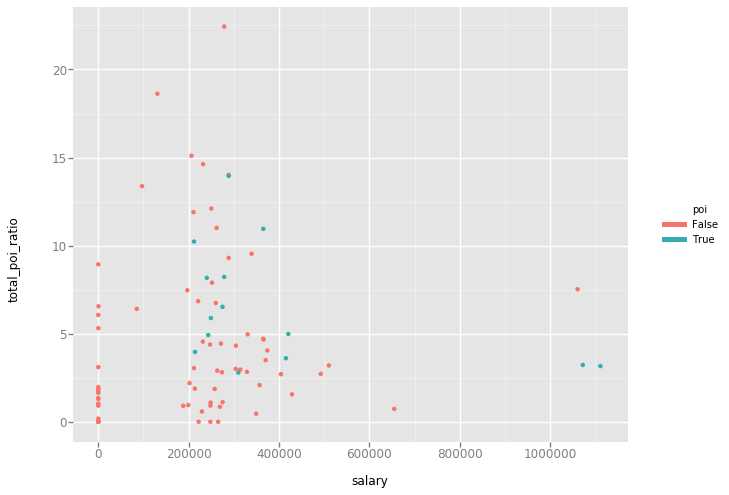

<ggplot: (283399853)>


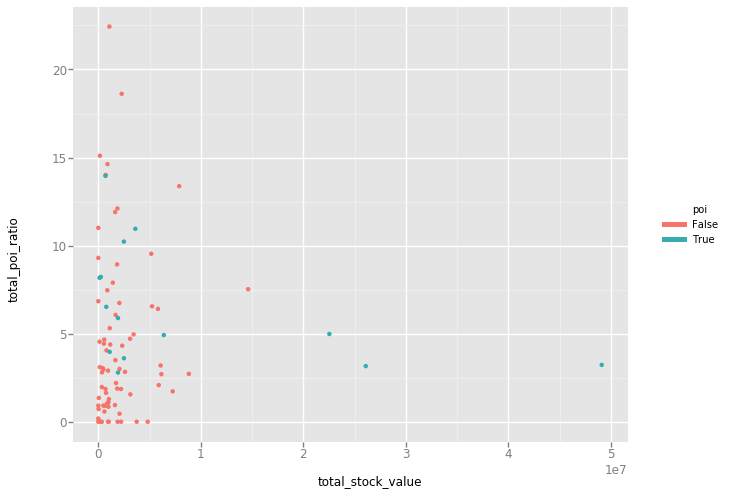

<ggplot: (282713781)>


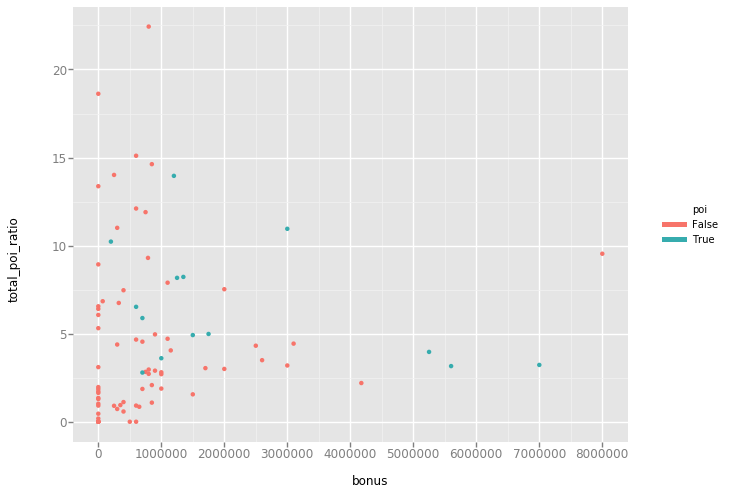

<ggplot: (283488989)>


In [8]:
Salary_poi = ggplot(aes(x='salary', y='total_poi_ratio', colour='poi'), data=df_ko) + geom_point()
print Salary_poi

Deferred_poi = ggplot(aes(x='total_stock_value', y='total_poi_ratio', colour='poi'), data=df_ko) + geom_point()
print Deferred_poi

Bonus_poi = ggplot(aes(x='bonus', y='total_poi_ratio', colour='poi'), data=df_ko) + geom_point()
print Bonus_poi

It appears there may be some correlation based on the visual estimate.

Now I will create some classifiers and run their scores to see if they have any accuracy.  I will further test for precision and recall.  I will then tune the best ones and select the very best as my final task. I will take a look at the resulting formating to make sure it is in an acceptable format for my machine learning algorythms.

In [8]:
labels = df_ko['poi'].copy(deep=True).astype(int).as_matrix()
features = (df_ko.drop('poi', axis=1)).fillna(0).copy(deep=True).as_matrix()
shuffle = sklearn.cross_validation.StratifiedShuffleSplit(labels, 4, test_size=0.3, random_state=0)

print labels
print features

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1]
[[  6.00000000e+05   0.00000000e+00   9.42990000e+04 ...,   4.66507177e+00
    3.44827586e+00   4.70879802e+00]
 [  1.20000000e+06   6.68054400e+06   1.12000000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.50000000e+05   4.89034400e+06   7.85520000e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  6.00000000e+05   3.18125000e+06   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  8.00000000e+05   7.65920000e+05   9.62680000e+04 ...,   2.24351747e+01
    5.00000000e+01   2.17341040e+01]
 [  6.00000000e+05   3.84728000e+05   1.25978000e+05 ...,   6.52418448e+00
    3.75000000e+01   5.95647194e+00]]


Decision Tree Classifier with Kfold for validating the results across different sections of the data. I will also print the list of best features.  Of course this list of features has been narrowed by taking out email addresses and director fees features as well as any feature that has more than 65 NaN values.   I ran this code first with the director fees feature included (but it was not usefull in predicting POI according to the features ranking) and found it easiest to delete it in a snipet of code above and re-run this section.

In [9]:
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.2, random_state=80)

###  KFold to split & validate 
from sklearn.cross_validation import KFold
kf=KFold(len(labels),5)
for train_indices, test_indices in kf:
    # training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

from sklearn.tree import DecisionTreeClassifier


t0 = time()

dt_clf = DecisionTreeClassifier()
dt_clf.fit(features_train,labels_train)
pred= dt_clf.predict(features_test)
score = dt_clf.score(features_test,labels_test)
recall=recall_score(labels_test, pred)

print 'accuracy before tuning', score
print 'recall = ', recall
print 'precision = ', precision_score(labels_test,pred)
scores = cross_validation.cross_val_score(dt_clf, features, labels)
print "DT cross val scores", scores

print "Decision tree algorithm time:", round(time()-t0, 3), "s"



importances = dt_clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

accuracy before tuning 0.714285714286
recall =  0.0
precision =  0.0
DT cross val scores [ 0.83333333  0.83333333  0.72340426]
Decision tree algorithm time: 0.027 s
Feature Ranking: 
1 feature salary (0.337137562515)
2 feature to_messages (0.253508143376)
3 feature deferral_payments (0.235900297125)
4 feature total_payments (0.0578179989945)
5 feature loan_advances (0.0578179989945)
6 feature bonus (0.0578179989945)
7 feature restricted_stock_deferred (0.0)
8 feature deferred_income (0.0)
9 feature total_stock_value (0.0)
10 feature expenses (0.0)
11 feature from_poi_to_this_person (0.0)
12 feature exercised_stock_options (0.0)
13 feature from_messages (0.0)
14 feature other (0.0)
15 feature from_this_person_to_poi (0.0)
16 feature long_term_incentive (0.0)


Naive Bayes, a simple classifier. It shows inconsistant cross val scores so it will not likely be the best option. I ran the test classifier and sure enough it could not beat the .3 recall & precision scores needed in spite of saying that it has adequet recall in the test below.  This highlights the importance of validation techniques.

Specifically in regards to validation in this project, I used kfold and cross validation to divide the data sets into test and training.  The test sets were not used in the model and then the model was tested on the test set to see how accurately it could predict POIs.  In fact, this was done three different times in the case above, and in three attempts to validate, the accuracy varied too much.  Meaning that if we had tried just one test set selection, we may have had misleading information as to the accuracy of the algorythm to predict whether or not a person is a POI.  Therefore, I will use validation techniques in all of my classifiers I am testing in this project.

In [10]:
from tester import test_classifier, dump_classifier_and_data
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
rec=recall_score(labels_test, pred)
print "NB accuracy", accuracy
print "NB Recall", rec
print 'NB precision = ', precision_score(labels_test,pred)

from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf, features, labels)

print "NB cross val scores", scores

print "NB algorithm run time:", round(time()-t0, 3), "s"


NB accuracy 0.714285714286
NB Recall 0.4
NB precision =  0.285714285714
NB cross val scores [ 0.85416667  0.89583333  0.76595745]
NB algorithm run time: 0.027 s


In [11]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()
params_log = {  "C":[0.05, 0.5, 1, 10, 10**2,10**5,10**10, 10**20],
                    "tol":[10**-1, 10**-5, 10**-10],
                    "class_weight":['balanced']
                    }

clf_log.fit(features_train, labels_train)
pred = clf_log.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
rec=recall_score(labels_test, pred)

print "Log accuracy", accuracy
print "Log Recall", rec
print 'Log precision = ', precision_score(labels_test,pred)

from sklearn import grid_search
cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=10)

def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0
                
from sklearn import grid_search

parameters = {'C' : [0.05, 0.5, 1, 10, 10**2,10**5,10**10, 10**20], 'tol' : [10**-1, 10**-5, 10**-10] }

clf_log = LogisticRegression()
clf_log_tune = GridSearchCV(clf_log, parameters, scoring = scoring, cv = cv)
clf_log_tune.fit(features, labels)

print clf_log_tune.best_estimator_
print clf_log_tune.best_score_



Log accuracy 0.642857142857
Log Recall 0.0
Log precision =  0.0


/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-10, verbose=0, warm_start=False)
0.666025437525


Support Vector Machine or SVC in sklearn.  Again, this is a relativily simple classifier but it has no recall when ran so will not likly be the right choice.

In [12]:

from sklearn.svm import SVC
clf = SVC(C=10000, kernel="rbf")
t0 = time()
clf.fit(features_train, labels_train)
print "training time:", round(time()-t0, 3), "s"
#t1 = time()
pred = clf.predict(features_test)
count = 0
for p in pred:
    if p == 1:
        count = count + 1
print "count:", count
#print "predicting time:", round(time()-t1, 3), "s"
t2 = time()
rec=recall_score(labels_test, pred)
accuracy = accuracy_score(pred,labels_test)
print "SVC accuracy", accuracy
print "SVC Recall", rec
from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf, features, labels)

print "SVC cross val scores", scores

training time: 0.01 s
count: 0
SVC accuracy 0.821428571429
SVC Recall 0.0
SVC cross val scores [ 0.875       0.875       0.87234043]


ADABoost is as popular choice for machine learning. And, it works well with this data too.  The feature rankings are different than the ones we found with the simple decision tree above.  This is the best result yet, and with some tuning may just be the winning classifier.  The only tuning I've done here is specify the n_estimators.  I tried different ones, and this number worked well.

In [13]:
from sklearn.ensemble import AdaBoostClassifier

adab_clf = AdaBoostClassifier(n_estimators=150)
adab_clf.fit(features_train, labels_train)
scores = sklearn.cross_validation.cross_val_score(adab_clf, features, labels)
pred = adab_clf.predict(features_test)
rec=recall_score(labels_test, pred)
accuracy = accuracy_score(pred,labels_test)
print "Adaboost accuracy", accuracy
print "Adaboost Recall", rec
print "Adaboost cross val scores", scores
print "Adaboost precision = ", precision_score(labels_test,pred)
importances = adab_clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print 'Feature Ranking: '
for i in range(16):
    print "{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]])

Adaboost accuracy 0.678571428571
Adaboost Recall 0.2
Adaboost cross val scores [ 0.85416667  0.875       0.80851064]
Adaboost precision =  0.166666666667
Feature Ranking: 
1 feature salary (0.133333333333)
2 feature to_messages (0.133333333333)
3 feature deferral_payments (0.12)
4 feature total_payments (0.113333333333)
5 feature loan_advances (0.106666666667)
6 feature bonus (0.08)
7 feature restricted_stock_deferred (0.0533333333333)
8 feature deferred_income (0.0466666666667)
9 feature total_stock_value (0.0466666666667)
10 feature expenses (0.04)
11 feature from_poi_to_this_person (0.04)
12 feature exercised_stock_options (0.02)
13 feature from_messages (0.02)
14 feature other (0.02)
15 feature from_this_person_to_poi (0.0133333333333)
16 feature long_term_incentive (0.0133333333333)


Adaboost is showing the most promise, but has not returned the .3 precision I am looking for. so I will optimize and tune Adaboost with the following code.

In [14]:

from sklearn import grid_search

cv = sklearn.cross_validation.StratifiedShuffleSplit(labels, n_iter=20)

def scoring(estimator, features_test, labels_test):
     labels_pred = estimator.predict(features_test)
     p = sklearn.metrics.precision_score(labels_test, labels_pred, average='micro')
     r = sklearn.metrics.recall_score(labels_test, labels_pred, average='micro')
     if p > 0.3 and r > 0.3:
            return sklearn.metrics.f1_score(labels_test, labels_pred, average='macro')
     return 0
                
from sklearn import grid_search
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
parameters = {'n_estimators' : [5, 10, 30, 40, 50, 75, 100,150], 'learning_rate' : [.001, 0.1, 0.5, 1, 1.5, 2, 2.5], 'algorithm' : ('SAMME', 'SAMME.R')}
adab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8))
adabclf = GridSearchCV(adab_clf, parameters, scoring = scoring, cv = cv)
adabclf.fit(features, labels)

print adabclf.best_estimator_
print adabclf.best_score_



AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=None)
0.708450748527


Now that we have a tuning that clearly imporves on the initial parameters, I can run it through the tester script and see how it performs. When tuning, the only parameters I gave for possible tests were the n_estimators, learning_rate, and algorythm.  I found that adding a smaller fraction of a number for the learning rate, worked well to improve my recall and precision for ada boost.  The tuner found that the best tuning was n_estimators = 50, learning rate =0.1 and it chose the SAMME algorythm over the SAMME.R. algorythm.  

The reason it is important to tune the parameters is because we want the algorythm to be able to predict whether or NOT a person is a POI accurately and consistantly.  In regards to recall, we are looking to achieve .3 or above.  This is the probability of the algorythm to accuractly predict a person is a POI when that person actually is a POI. A recall of .3 tells us that 30 percent of the time when a person is actually a POI the classifer will identify it as such.  


We are looking also for a precision of .3 or above.  Precision in this case tells us how precise the predictions (using a test set) of the classifier are. In other words it tells us that if a person is identfied as a POI by the classifier, how likely that person is to actually be a POI.  In this case 30% or more likely.  Not fantasic, but given the limited number of example POI's it is actually remarkable.

Finally, we have accuracy which is important because recall and precision do not take into account true negatives (In this case, the times the classifier accuratley predicts that a person is not a POI). It tells us how good the algorythm is at guessing whether a person is or is NOT a POI.

It is important to tune because we could have a high recall but a low precision which would mean that its great at picking a POI when they are a POI but terrible when the person is not.  In otherwords it would likely tell you a non-POI is a POI more than 70% of the time.  Making the recall basically useless and non-selective.

On the otherhand, we could have a high precision but terrible recall. This would mean that it would be bad at identifying a POI who is a POI but when it did guess correctly, it would rearely identyfy a non-POI as a POI. 


In [15]:
from tester import test_classifier, dump_classifier_and_data
adab_best_clf = adabclf.best_estimator_
list_cols = list(df_ko.columns.values)
list_cols.remove('poi')
list_cols.insert(0, 'poi')
data = df_ko[list_cols].fillna(0).to_dict(orient='records')
enron_data_sub = {}
counter = 0
for item in data:
    enron_data_sub[counter] = item
    counter += 1

test_classifier(adab_best_clf, enron_data_sub, list_cols)


AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=None)
	Accuracy: 0.82073	Precision: 0.32715	Recall: 0.32600	F1: 0.32657	F2: 0.32623
	Total predictions: 15000	True positives:  652	False positives: 1341	False negatives: 1348	True negatives: 11659



Hurray it works!! The precision and recall came up above the .3 mark.  Maybe if I scale the features it will be more accurate?  No, it does not improve the recall or the precision.  Overall, it is not helpful.

In [16]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)

from tester import test_classifier, dump_classifier_and_data
adab_best_clf = adabclf.best_estimator_
list_cols = list(df_ko.columns.values)
list_cols.remove('poi')
list_cols.insert(0, 'poi')
data = df_ko[list_cols].fillna(0).to_dict(orient='records')
enron_data_sub = {}
counter = 0
for item in data:
    enron_data_sub[counter] = item
    counter += 1

test_classifier(adab_best_clf, enron_data_sub, list_cols)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=None)
	Accuracy: 0.81800	Precision: 0.32178	Recall: 0.32950	F1: 0.32559	F2: 0.32793
	Total predictions: 15000	True positives:  659	False positives: 1389	False negatives: 1341	True negatives: 11611



Now, I will run a Logistic regression with PCA to select the most important components that predict if a person is a person of interest or not. I used my best features list from my earlier decision tree classifier.  I had to use pipeline and StandardScaler in order to pass the information and tune it as well as scale it.

In [17]:
def tune_logistic_regression():

    skb = SelectKBest()
    pca = PCA()
    lr_clf = LogisticRegression()

    pipe_lr = Pipeline(steps=[("SKB", skb), ("PCA", pca), ("LogisticRegression", lr_clf)])

    lr_k = {"SKB__k": range(9, 10)}
    lr_params = {'LogisticRegression__C': [1e-08, 1e-07, 1e-06],
                 'LogisticRegression__tol': [1e-2, 1e-3, 1e-4],
                 'LogisticRegression__penalty': ['l1', 'l2'],
                 'LogisticRegression__random_state': [42, 46, 60]}
    lr_pca = {"PCA__n_components": range(3, 8), "PCA__whiten": [True, False]}

    lr_k.update(lr_params)
    lr_k.update(lr_pca)

    enron.get_best_parameters_reports(pipe_lr, lr_k, features, labels)


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
my_dataset = data_dict
features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock'] 



# Select 16 best features 
best_features_list_lr = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive']


### Re-extracting features to be compatiable
data = featureFormat(my_dataset, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)
def get_k_best(data_dict, features_list, k):

    data = featureFormat(df_ko, features_list)
    labels_train, features_train = targetFeatureSplit(data)

    k_best = SelectKBest(f_classif, k=k)
    k_best.fit(features_train, labels_train)

    unsorted_list = zip(features_list[1:], k_best.scores_)
    sorted_list = sorted(unsorted_list, key=lambda x: x[1], reverse=True)
    k_best_features = dict(sorted_list[:k])

    return ['poi'] + k_best_features.keys()

### Each classifier and tune

def tune_logistic_regression():

    skb = SelectKBest()
    pca = PCA()
    lr_clf = LogisticRegression()

    pipe_lr = Pipeline(steps=[("SKB", skb), ("PCA", pca), ("LogisticRegression", lr_clf)])

    lr_k = {"SKB__k": range(9, 10)}
    lr_params = {'LogisticRegression__C': [1e-08, 1e-07, 1e-06],
                 'LogisticRegression__tol': [1e-2, 1e-3, 1e-4],
                 'LogisticRegression__penalty': ['l1', 'l2'],
                 'LogisticRegression__random_state': [42, 46, 60]}
    lr_pca = {"PCA__n_components": range(3, 8), "PCA__whiten": [True, False]}

    lr_k.update(lr_params)
    lr_k.update(lr_pca)

    enron.get_best_parameters_reports(pipe_lr, lr_k, features, labels)


#tuneLOGReg
labels = df_ko['poi'].copy(deep=True).astype(int).as_matrix()
features = (df_ko.drop('poi', axis=1)).fillna(0).copy(deep=True).as_matrix()

clf_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4, whiten=False)),
    ('classifier', LogisticRegression(tol=0.01, C=1e-08, penalty='l2', random_state=42))])

print "Logistic Regression : \n", test_classifier(clf_lr, my_dataset, best_features_list_lr)
clf_lr = clf
features_list = best_features_list_lr


Logistic Regression : 
Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False))])
	Accuracy: 0.81080	Precision: 0.32856	Recall: 0.40150	F1: 0.36139	F2: 0.38443
	Total predictions: 15000	True positives:  803	False positives: 1641	False negatives: 1197	True negatives: 11359

None


The logistic regression with PCA Worked the best!  The classifier boiled all of that info down to just 4 components which are a composite of my best chosen features.  In regards to my features that I added, "from_poi_to_this_person", "from_this_person_to_poi", and "shared_receipt_with_poi", I tested each classifier with and without the new features and found them to improve the recall and precision slightly in each case.  Therefore, I left them in the features list.

Unfortunately, I was not able to get the PCA pipeline to work with the tester script provided.  Consequentially, the poi_id.py script uses ADAboost instead to achieve the minimum recall and precision required for the project.

Reflecting back, I spent days trying to break past .30 accuracy without pca, and finally it took removing the features where there was more than 65 NaN values.  Just removing columns that the decsion tree classifier ranking said were useless did not help.  Also removing features with more than 150 NaNs did not work either.  This was a learning opportunity particularly because I realized good data cleaning can be more important than any fancy algorythm.  Then, I was able to make PCA work and received an even better result. In the end, the 3 features I created with ratios of emails to and from POI were not signifcant predictors, and were tossed out because they had too many NaN values.  I ran the classifiers with them, and could not break .3 recall/precsision.  The other difficult thing about this data is that we had so few known POI to go off.  If we had more, we could have built a classifier that returned a much higher Recall and Precision.
